# 撰寫指數型策略以及做參數優化
利用乖離率將加權指數做買賣的動作

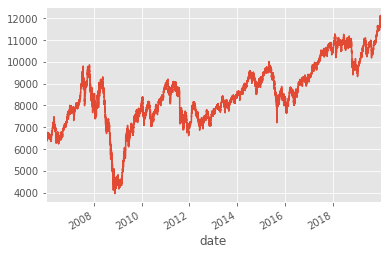

In [18]:
from finlab.data import Data
import matplotlib.pyplot as plt
%matplotlib inline

data = Data()
twii = data.get('發行量加權股價指數')
# 每一分鐘的整點取一次股價
twii = twii[(twii.index.second == 0)]['台股指數']
twii.tail()
plt.style.use("ggplot")
twii.plot()

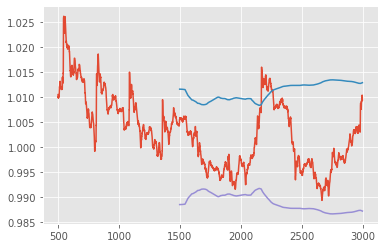

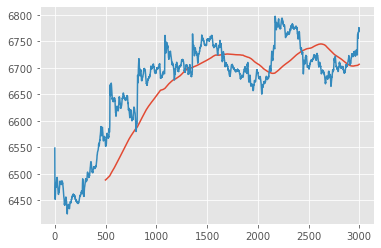

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

sma = twii.rolling(500).mean()
bias = twii / sma

ub = 1 + bias.rolling(1000).std() * 2
lb = 1 - bias.rolling(1000).std() * 2

plt.plot(bias.values[:3000])
plt.plot(ub.values[:3000])
plt.plot(lb.values[:3000])

plt.show()

plt.plot(sma.values[:3000])
plt.plot(twii.values[:3000])

## 乖離率策略
滑價：今天在做買賣時跟回測時數值的不同的成本。 ex:今天模擬買入的價格是3元，但實際買入是6元，中間的滑假就是3元

2937.9000000000115

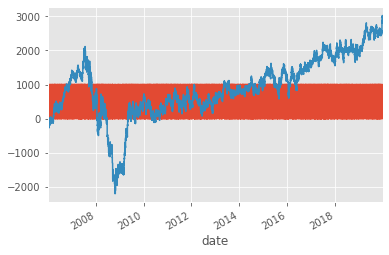

In [27]:
import numpy as np
import pandas as pd
%matplotlib inline

def strategy(m1=500, m2=1000, m3=1, m4=1, draw_plot=False):
    sma = twii.rolling(m1).mean()
    bias = (twii / sma)
    ub = 1 + bias.rolling(m2).std() * m3
    lb = 1 - bias.rolling(m2).std() * m4
    
    buy = (bias < lb) 
    sell = (bias > ub)

    hold = pd.Series(np.nan, index=sell.index)
    hold[buy] = 0
    hold[sell] = 1 # 有持有的部分
    hold = hold.ffill()
    
    #ㄐㄧ
    returns = twii.shift(-2) - twii.shift(-1) 
    returns[hold == 0] = 0
    # 扣掉手續費，從0變1 or 1變0計算差值，手續費計算成是加權股價指數的三點
    # 交易手續費跟滑價的部分
    returns -= hold.diff().abs() * 3 
    creturn = returns.cumsum()
    if draw_plot:
        (hold*1000).plot()
        creturn.plot()
    return creturn.dropna()[-1]
strategy(draw_plot=True)

## 乖離率優化

利用參數優化找出最適合的參數，並將最後的策略績效畫出來

2587.079999999991 500 400 1 1
2894.4799999999923 500 420 1 1
3034.8199999999906 500 460 1 1
3078.7599999999993 500 480 1 1
3260.150000000005 500 560 1 1
3678.1500000000233 500 600 1 1
3694.8600000000106 500 620 1 1
4160.290000000011 500 640 1 1
6023.6799999999785 700 400 1 1
6451.23999999999 700 420 1 1
6551.050000000003 700 440 1 1
7411.130000000004 700 460 1 1
7591.390000000011 1100 400 1 1
7922.229999999999 1300 400 1 1
7971.210000000001 1300 420 1 1
8051.229999999994 1300 740 1 1
8176.439999999988 1300 780 1 1
8320.320000000002 1700 620 1 1


8320.320000000002

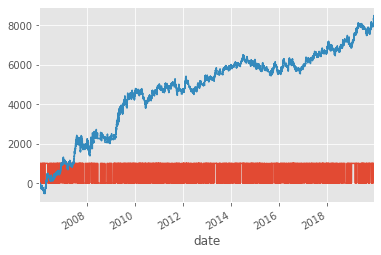

In [25]:
vmax = 0
for m1 in range(500, 2000, 200): # 500到2000每200個單位跑一次
    for m2 in range(400, 800, 20):
        v = strategy(m1, m2, 1, 1)
        if v > vmax:
            vmax = v
            print(vmax, m1, m2, 1, 1)
strategy(1700, 620, 1, 1, draw_plot=True)